In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Read dataset file
df = pd.read_csv('BTC1.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df

,Price
0,13444.9
1,14754.1
2,15156.6
3,15180.1
4,16954.8
...,...
1938,27591.4
1939,27509.3
1940,28298.8
1941,28424.6


In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
#Holt-Winters Exponential Smoothing model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Define the kernel
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + \
         RationalQuadratic(length_scale=1.0, alpha=0.1) + \
         ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(0.1, 10.0)) + \
         WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))

# Define the model
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)

# Train the model
model.fit(x_train, y_train)

C:\Users\Duy Khanh\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Duy Khanh\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Duy Khanh\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Duy Khanh\anaconda3\lib\site-packages\sklearn\ga

GaussianProcessRegressor(alpha=0.1,
                         kernel=RBF(length_scale=1) + RationalQuadratic(alpha=0.1, length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
                         normalize_y=True)

In [5]:
# make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred, y_std = model.predict(x_test, return_std=True)

# make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_vpred, y_vstd = model.predict(x_val, return_std=True)

In [6]:
# Forecast the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days, y_next_30_day_std = model.predict(x_next_30_days, return_std=True)

# Print the predicted closing prices for the next 30 days
print('Predicted Bitcoin closing prices for the next 30 days:')
y_next_30_days

Predicted Bitcoin closing prices for the next 30 days:


array([18946.66816078, 18938.74236465, 18930.87308763, 18923.05995827,
       18915.30260694, 18907.60066583, 18899.95376895, 18892.36155214,
       18884.82365299, 18877.33971096, 18869.90936731, 18862.53226506,
       18855.20804908, 18847.93636599, 18840.71686427, 18833.54919413,
       18826.4330076 , 18819.36795849, 18812.35370243, 18805.38989674,
       18798.47620061, 18791.61227495, 18784.79778248, 18778.03238765,
       18771.31575667, 18764.64755754, 18758.02746001, 18751.45513555,
       18744.93025742, 18738.45250057])

In [7]:
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAPE:", test_mape)

Validation RMSE: 5307.934928899657
Testing RMSE: 10459.114293058561
Validation MAPE: 20.285409130172614
Testing MAPE: 19.714404285373334
Validation MAE: 4531.664806930029
Testing MAPE: 19.714404285373334


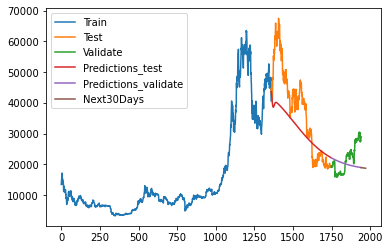

In [13]:
# ploting the actual values and predicted values
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_vpred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test','Validate', 'Predictions_test','Predictions_validate','Next30Days'])
plt.show()